In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from portfolio.utils import load_prices, compute_returns
from measures.ot.copulas import simulate_reference_copula, empirical_copula_transform, empirical_copula_hist


def plot_reference_copulas(n_bins: int = 20, n_samples: int = 50_000):
    kinds = ["independence", "comonotonic", "countermonotonic"]
    titles = [
        "Independence copula",
        "Comonotonic copula (Fréchet upper bound)",
        "Countermonotonic copula (Fréchet lower bound)",
    ]

    fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

    for ax, kind, title in zip(axes, kinds, titles):
        H = simulate_reference_copula(
            kind=kind,
            n_samples=n_samples,
            n_bins=n_bins,
            random_state=42,
        )

        # imshow expects [row, col] with row = y, col = x
        # extent makes axes show 0..1 on both dimensions
        im = ax.imshow(
            H,
            origin="lower",
            extent=[0, 1, 0, 1],
            aspect="equal",
        )
        ax.set_title(title)
        ax.set_xlabel(r"$u$")
        ax.set_ylabel(r"$v$")

        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="density")

    fig.suptitle(f"Reference copulas (n_bins={n_bins}, n_samples={n_samples})")
    plt.show()

def plot_asset_copula(
    path="data/smi_prices_cleaned.xlsx",
    asset_x="KNIN.S",
    asset_y="NESN.S",
    n_bins=20,
):
    # 1) Load prices
    df_prices = load_prices(path)

    # 2) Compute returns
    df_ret = compute_returns(df_prices).dropna()

    # 3) Select the two assets
    x = df_ret[asset_x].values
    y = df_ret[asset_y].values

    # 4) Transform to pseudo-observations (Copula space)
    u = empirical_copula_transform(x)
    v = empirical_copula_transform(y)

    # 5) Compute histogram (empirical copula)
    H = empirical_copula_hist(u, v, n_bins=n_bins)

    # 6) Plot scatter + heatmap
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Scatter of (U, V)
    axs[0].scatter(u, v, s=5, alpha=0.4)
    axs[0].set_title(f"Pseudo-observations (U, V): {asset_x} vs {asset_y}")
    axs[0].set_xlabel("U")
    axs[0].set_ylabel("V")
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)

    # Heatmap of empirical copula
    im = axs[1].imshow(
        H,
        origin="lower",
        extent=[0, 1, 0, 1],
        aspect="equal",
    )
    axs[1].set_title(f"Empirical Copula Histogram ({n_bins}x{n_bins})")
    axs[1].set_xlabel("U")
    axs[1].set_ylabel("V")

    fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04, label="density")
    plt.suptitle(f"Empirical Copula for {asset_x} and {asset_y}")
    plt.tight_layout()
    plt.show()

def plot_asset_copula_contour(
    path="data/smi_prices_cleaned.xlsx",
    asset_x="KNIN.S",
    asset_y="NESN.S",
    n_bins=20,
):
    # 1) Load prices
    df_prices = load_prices(path)

    # 2) Compute returns
    df_ret = compute_returns(df_prices).dropna()

    # 3) Select the two assets
    x = df_ret[asset_x].values
    y = df_ret[asset_y].values

    # 4) Transform returns → copula space
    u = empirical_copula_transform(x)
    v = empirical_copula_transform(y)

    # 5) Build empirical copula histogram
    H = empirical_copula_hist(u, v, n_bins=n_bins)

    # 6) Create grid for contour plotting
    xs = np.linspace(0, 1, n_bins)
    ys = np.linspace(0, 1, n_bins)

    X, Y = np.meshgrid(xs, ys)

    # 7) Create figure with 3 panels
    fig, axs = plt.subplots(1, 3, figsize=(16, 5))

    # --- Scatter plot ---
    axs[0].scatter(u, v, s=5, alpha=0.4)
    axs[0].set_title(f"Pseudo-observations (U, V)\n{asset_x} vs {asset_y}")
    axs[0].set_xlabel("U")
    axs[0].set_ylabel("V")
    axs[0].set_xlim(0, 1)
    axs[0].set_ylim(0, 1)

    # --- Heatmap ---
    im = axs[1].imshow(
        H,
        origin="lower",
        extent=[0, 1, 0, 1],
        aspect="equal",
    )
    axs[1].set_title(f"Empirical Copula Heatmap ({n_bins}x{n_bins})")
    axs[1].set_xlabel("U")
    axs[1].set_ylabel("V")
    fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

    # --- Contour plot (smooth view of copula density) ---
    cs = axs[2].contourf(
        X, Y, H,
        levels=12,   # number of contour levels
        cmap="viridis",
    )
    axs[2].set_title("Empirical Copula Contour Plot")
    axs[2].set_xlabel("U")
    axs[2].set_ylabel("V")
    fig.colorbar(cs, ax=axs[2], fraction=0.046, pad=0.04)

    plt.suptitle(f"Empirical Copula for {asset_x} and {asset_y}", fontsize=14)
    plt.tight_layout()
    plt.show()

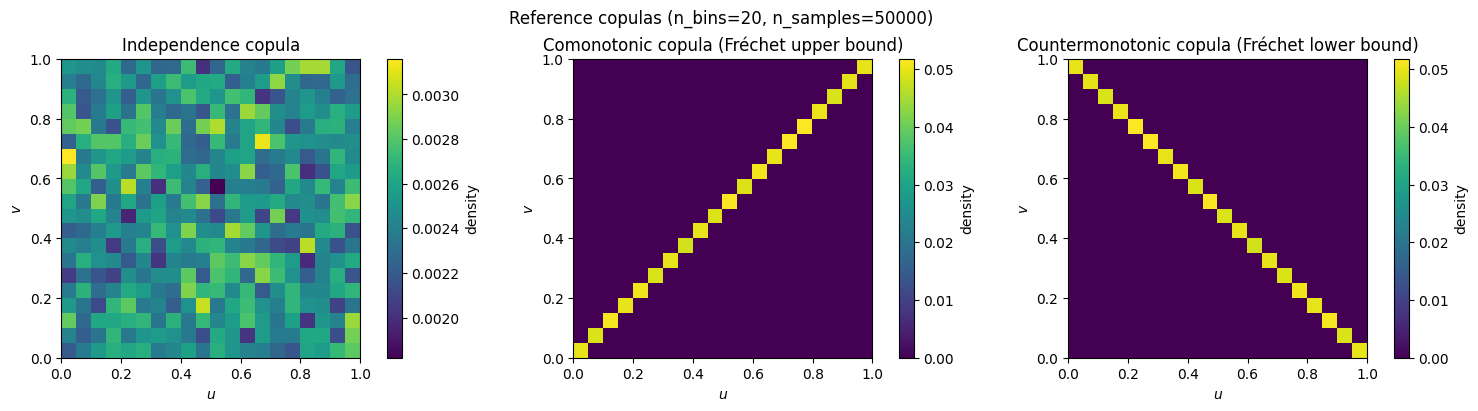

In [9]:
plot_reference_copulas(n_bins=20, n_samples=50_000)

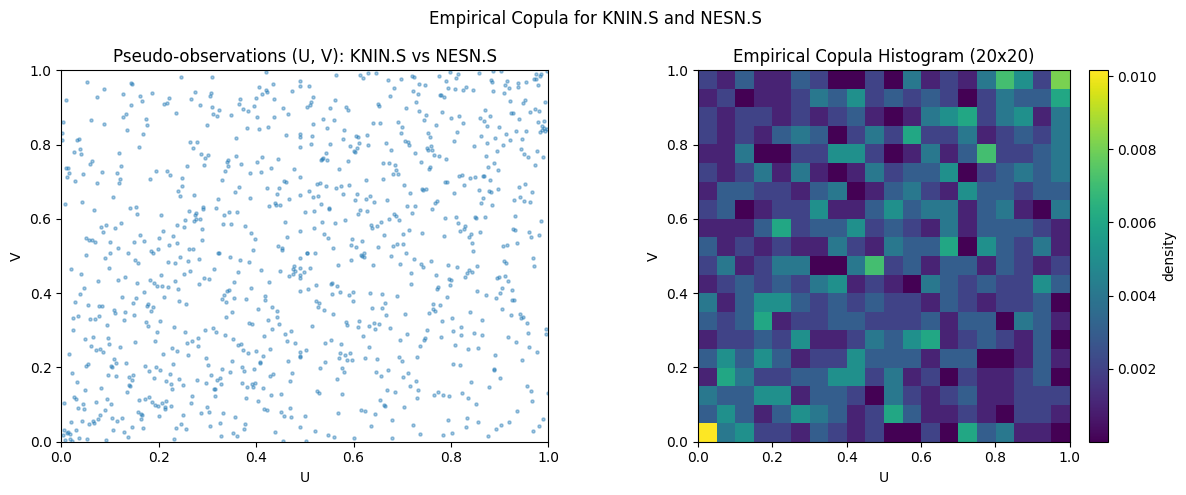

In [10]:
plot_asset_copula(
        asset_x="KNIN.S",
        asset_y="NESN.S",
        n_bins=20,
    )

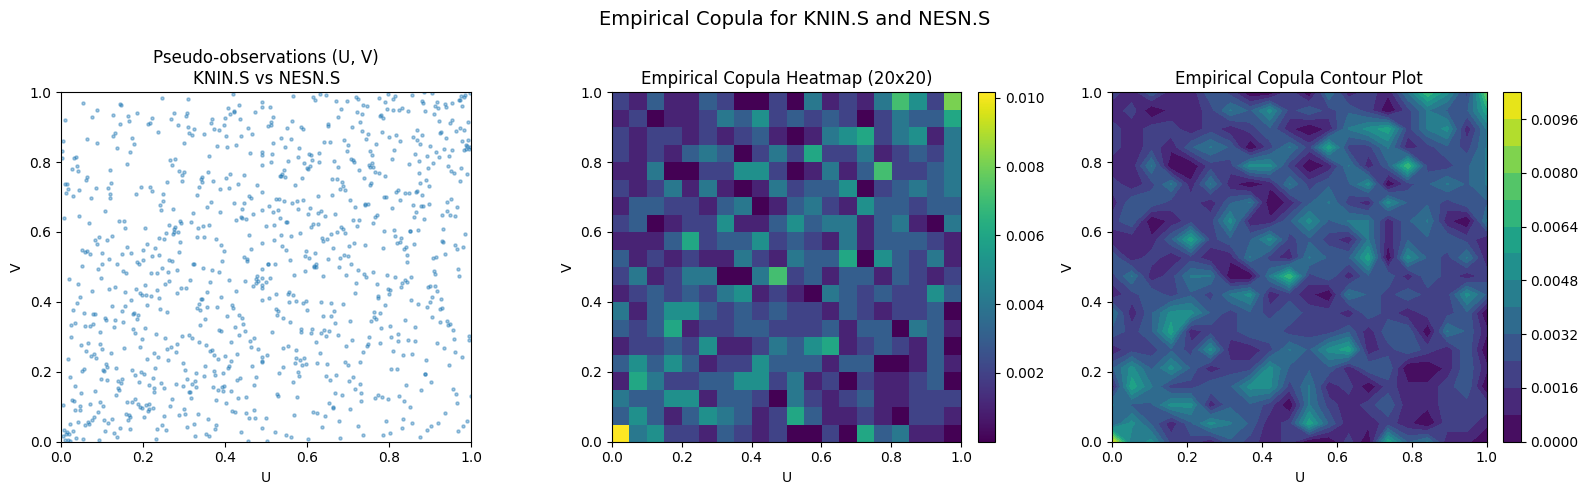

In [11]:
plot_asset_copula_contour(
        asset_x="KNIN.S",
        asset_y="NESN.S",
        n_bins=20,
    )

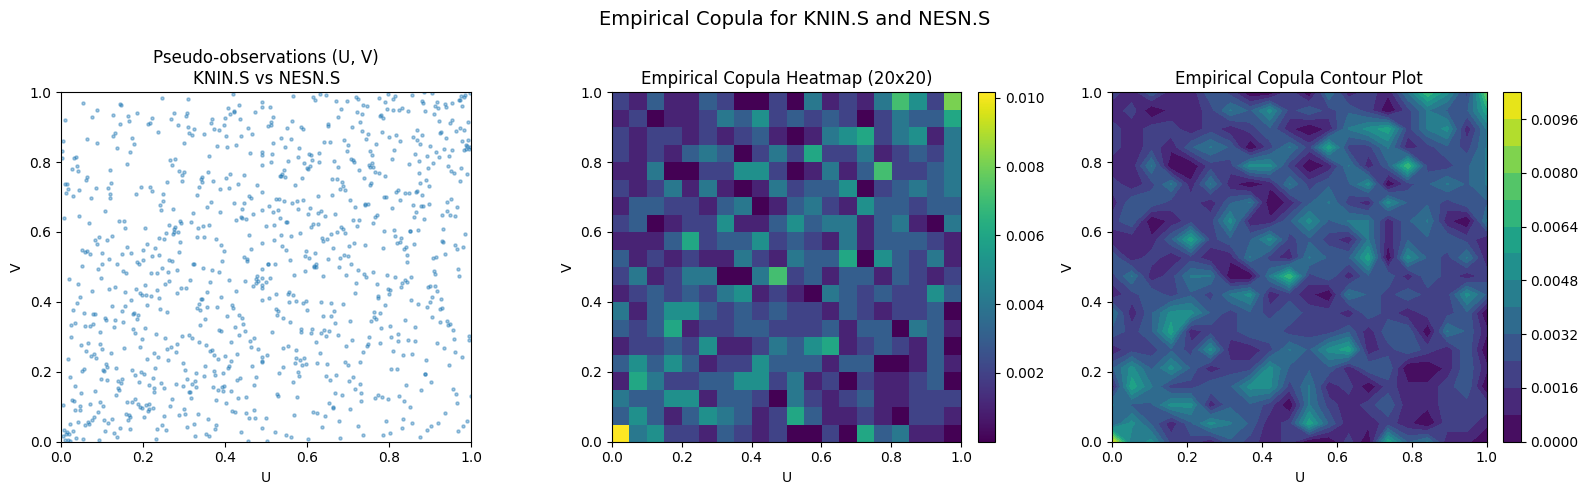

In [12]:
plot_asset_copula_contour(
        asset_x="KNIN.S",
        asset_y="NESN.S",
        n_bins=20,
    )

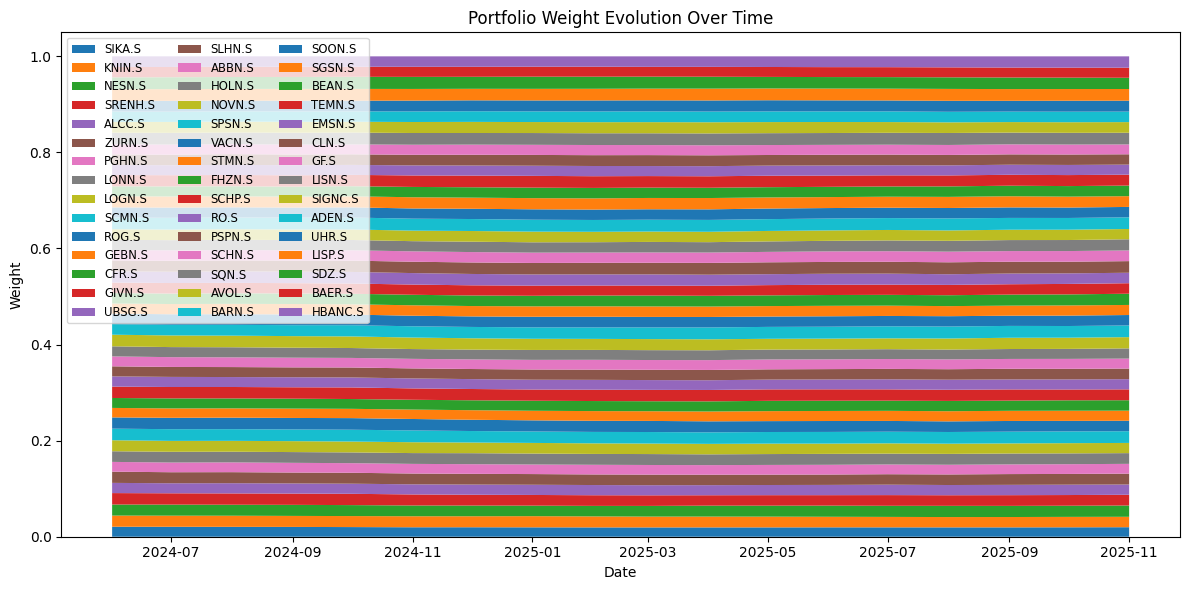

In [14]:
# Load weights
path = "ot_weights.csv"
df = pd.read_csv(path)

# Try to infer date column
# Assume first column is date-like
date_col = df.columns[0]
df[date_col] = pd.to_datetime(df[date_col])
df = df.set_index(date_col)

# Plot weight evolution as stacked area chart
fig, ax = plt.subplots(figsize=(12,6))
ax.stackplot(df.index, df.T.values, labels=df.columns)
ax.set_title("Portfolio Weight Evolution Over Time")
ax.set_ylabel("Weight")
ax.set_xlabel("Date")
ax.legend(loc="upper left", fontsize="small", ncol=3)
plt.tight_layout()

plt.show()